In [1]:
from IPython.display import Image

Contents
--------
1. What is machine learning
2. Different ways of learning from data
3. Why probabilistic graphical models
4. Major types of PGMs

### 1. What is machine learning
Machine learning is a scientific discipline that explores the construction and study of algorithms that can learn from data. Such algorithms operate by building a model from example inputs and using that to make predictions or decisions, rather than following strictly static program instructions.

We can take an example of predicting the type of flower based on the sepal length and width of the flower. Let's say we have some data (discretized iris data set on sepal length and width). The dataset looks something like this:

In [2]:
%run ../scripts/1/discretize.py
data

,length,width,type
134,6,3,2
148,6,3,2
25,5,3,0
48,5,4,0
86,7,3,1
...,...,...,...
79,6,3,1
26,5,3,0
101,6,3,2
71,6,3,1


### 2. Different ways of learning from data

Now let's say we want to predict the type of flower for a new given data point. There are multiple ways to solve this problem. We will consider these two ways in some detail:  

1. We could find a function which can directly map an input value to it's class label. 
2. We can find the probability distributions over the variables and then use this distribution to answer queries about the new data point.

There are a lot of algorithms for finding a mapping function. For example linear regression tries to find a linear equation which explains the data. Support vector machine tries to find a plane which separates the data points. Decision Tree tries to find a set of simple greater than and less than equations to classify the data. Let's try to apply Decision Tree on this data set.

We can plot the data and it looks something like this:

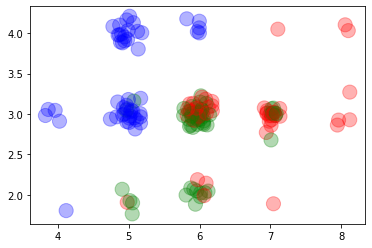

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Adding a little bit of noise so that it's easier to visualize
data_with_noise = data.iloc[:, :2] + np.random.normal(loc=0, scale=0.1, size=(150, 2))
plt.scatter(data_with_noise.length, data_with_noise.width, c=[ "bgr"[k] for k in data.iloc[:,2] ], s=200, alpha=0.3)

In the plot we can easily see that the blue points are concentrated on the top-left corner, green ones in bottom left and red ones in top right. 

Now let's try to train a Decision Tree on this data.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['length', 'width']].values, data.type.values, test_size=0.2)

classifier = DecisionTreeClassifier(max_depth=4)
classifier.fit(X_train, y_train)
classifier.predict(X_test)

array([0, 2, 0, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2])

In [5]:
classifier.score(X_test, y_test)

0.5666666666666667

So, in this case we got a classification accuracy of 60 %.

Now moving on to our second approach using a probabilistic model.
The most obvious way to do this classification task would be to compute a Joint Probability Distribution over all these variables and then marginalize and reduce over these according to our new data point to get the probabilities of classes.

In [6]:
X_train, X_test = data[:120], data[120:]

In [7]:
X_train

,length,width,type
134,6,3,2
148,6,3,2
25,5,3,0
48,5,4,0
86,7,3,1
...,...,...,...
135,8,3,2
6,5,3,0
69,6,2,1
139,7,3,2


In [8]:
# Computing the joint probability distribution over the training data
joint_prob = data.groupby(['length', 'width', 'type']).size() / 120
joint_prob

length  width  type
4       2      0       0.008333
        3      0       0.033333
5       2      1       0.033333
               2       0.008333
        3      0       0.191667
               1       0.016667
        4      0       0.141667
6       2      1       0.075000
               2       0.025000
        3      1       0.225000
               2       0.200000
        4      0       0.041667
7       2      2       0.008333
        3      1       0.066667
               2       0.116667
        4      2       0.008333
8       3      2       0.033333
        4      2       0.016667
dtype: float64

In [9]:
# Predicting values

# Selecting just the feature variables.
X_test_features = X_test.iloc[:, :2].values
X_test_actual_results = X_test.iloc[:, 2].values

predicted_values = []
for i in X_test_features:
    predicted_values.append(joint_prob[i[0], i[1]].idxmax())
    
predicted_values = np.array(predicted_values)
predicted_values

array([1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1])

In [10]:
# Comparing results with the actual data.
predicted_values == X_test_actual_results

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True, False,  True,  True, False, False,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False])

In [11]:
score = (predicted_values == X_test_actual_results).sum() / 30
print(score)

0.6333333333333333


### Why Probabilistic Graphical Models

In the previous example we saw how Bayesian Inference works. We construct a Joint Distribution over the data and then condition on the observed variable to compute the posterior distribution. And then we query on this posterior distribution to predict the values of new data points.

But the problem with this method is that the Joint Probability Distribution is exponential to the number of states (cardinality) of each variable. So, for problems having a lot of features or having high cardinality of features, inference becomes a difficult task because of computational limitations. For example, for 10 random variables each having 10 states, the size of the Joint Distribution would be 10^10.

__Proababilistic Graphical Models (PGM)__: PGM is a technique of compactly representing Joint Probability Distribution over random variables by exploiting the (conditional) independencies between the variables. PGM also provides us methods for efficiently doing inference over these joint distributions.

Each graphical model is characterized by a graph structure (can be directed, undirected or both) and a set of parameters associated with each graph.

The problem in the above example can be represented using a Bayesian Model (a type of graphical model) as:

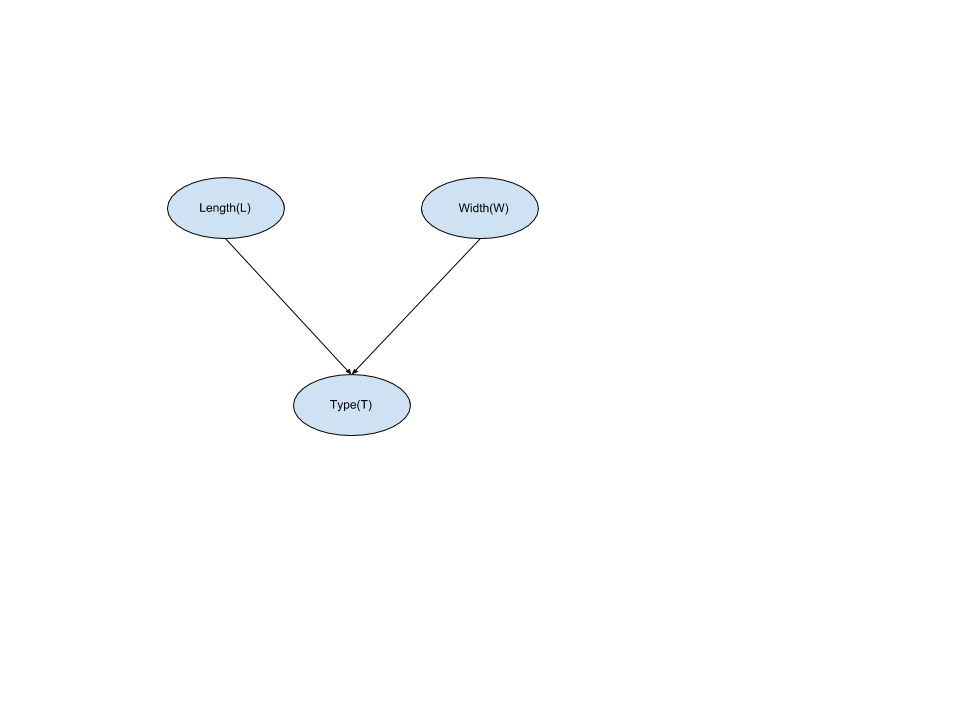

In [12]:
Image(filename='../images/1/Iris_BN.png')

In this case the parameters of the network would be $ P(L) $, $ P(W) $ and $ P(T | L, W) $. So, we will need to store 5 values for $ L $, 3 values for $ W $ and 45 values for $ P(T | L, W) $. So, a total of 45 + 5 + 3 = 53 values to completely parameterize the network which is actually more than 45 values which we need for $ P (T, L, W) $. But in the cases of bigger networks graphical models help in saving space. We can take the example of the student network shown below:

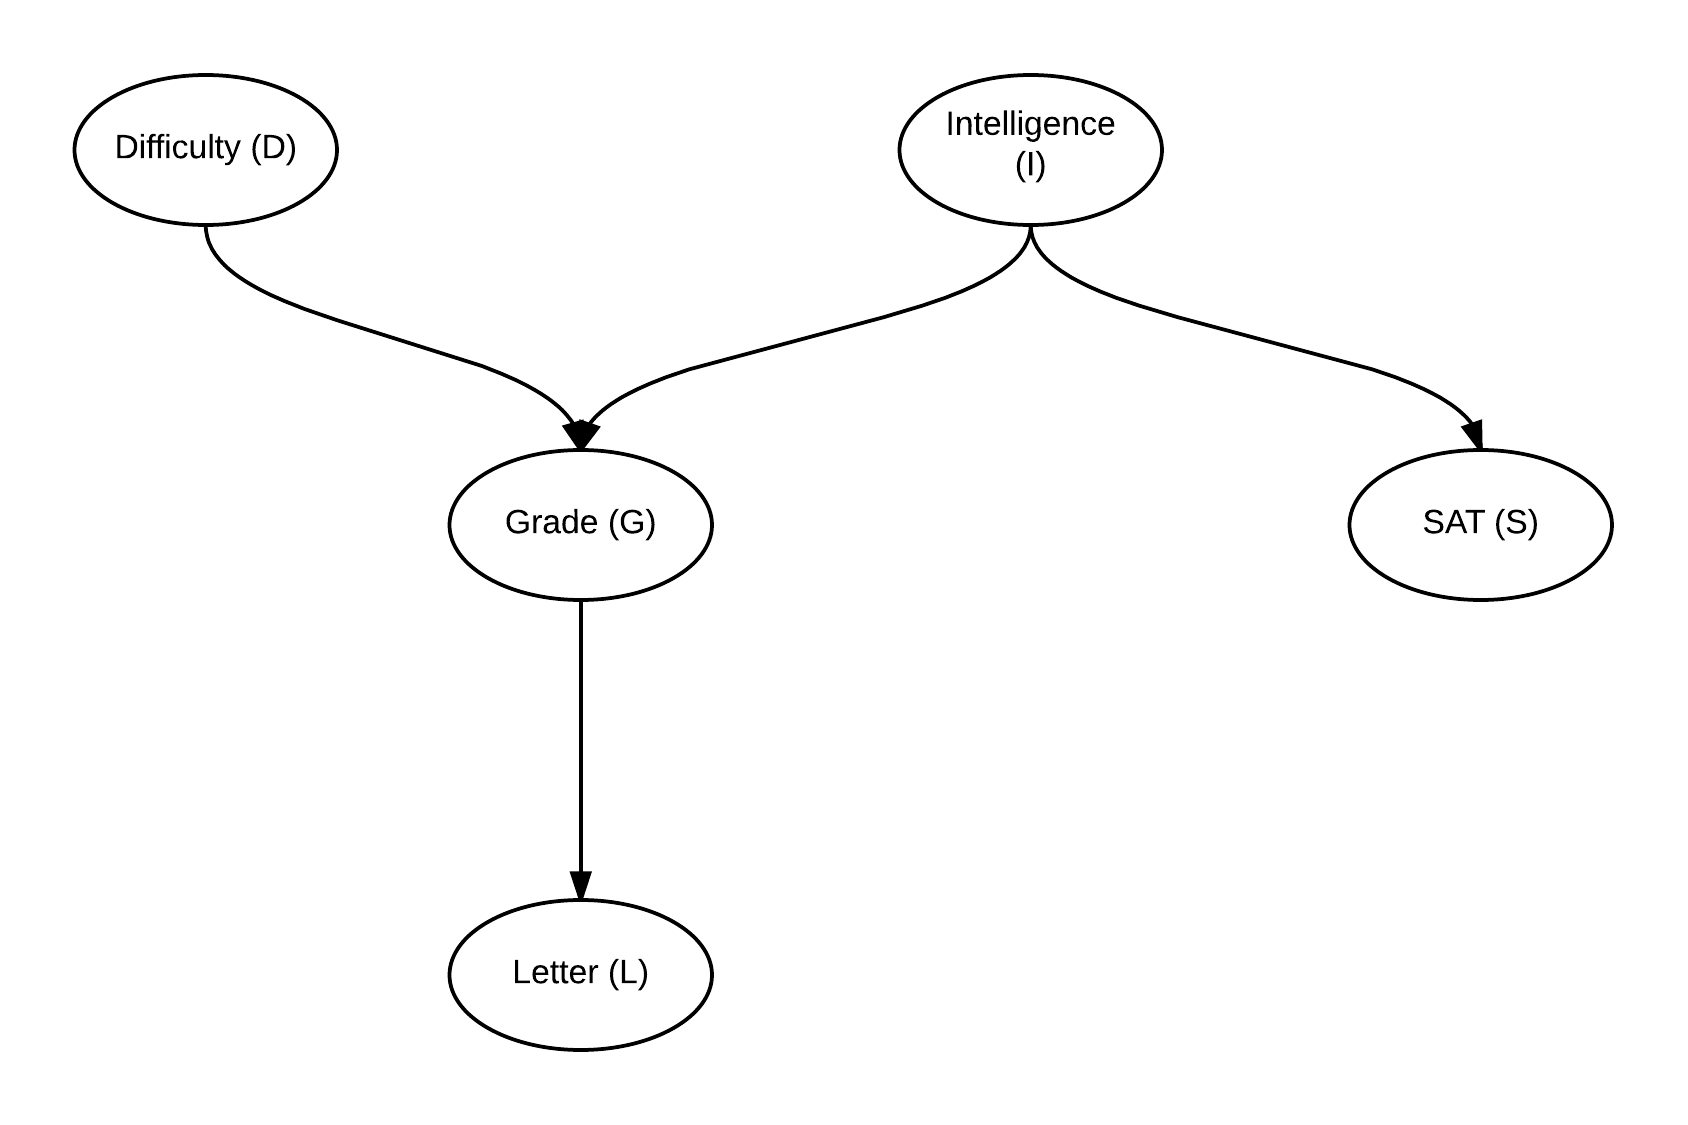

In [13]:
Image(filename='../images/1/student.png')

Considering that $ D $ has cardinality of 2, $ I $ has cardinality of 2, $ S $ has cardinality of 2, $ G $ has cardinality of 3 and $ L $ has cardinality of 2. Also the parameters in this network would be $ P(D) $, $ P(I) $, $ P(S | I) $, $ P(G | D, I) $, $ P(L | G) $. So, the number of values needed would be $ 2 $ for $ P(D) $, $ 2 $ for $ P(I) $, $ 12 $ for $ P(G | D, I) $, $ 6 $ for $ P(L | G) $, $ 4 $ for $ P(S | I) $, total of $ 4 + 6 + 12 + 2 + 2 = 26 $ compared to $ 2 * 2 * 3 * 2 * 2 = 48 $ required for the Joint Distribution over all the variables. 

#### Types of Graphical Models

There are mainly 2 types of graphical models:
1. Bayesian Models: A Bayesian Model consists of a directed graph and Conditional Probability Distributions(CPDs) associated with each of the node. Each CPD is of the form $ P(node | parents(node)) $ where $ parents(node) $ are the parents of the node in the graph structure.
2. Markov Models: A Markov Models consists of an undirected graph and are parameterized by Factors. Factors  
represent how much 2 or more variables agree with each other.